# Part I: CNN Classification

- Load the necessary lib

In [1]:
!pip install torchinfo


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from torchinfo import summary
import torch.nn.functional as F
import plotly
import scipy.stats as stats
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

import time
from torch.utils.data import Dataset, DataLoader

import os
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from PIL import Image
from collections import Counter
from torchsummary import summary
import random


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip '/content/drive/MyDrive/DL/cnn_dataset.zip' -d '/content/dataset'

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/vehicles/5499.jpg  
  inflating: /content/dataset/vehicles/55.jpg  
  inflating: /content/dataset/vehicles/550.jpg  
  inflating: /content/dataset/vehicles/5500.jpg  
  inflating: /content/dataset/vehicles/5501.jpg  
  inflating: /content/dataset/vehicles/5502.jpg  
  inflating: /content/dataset/vehicles/5503.jpg  
  inflating: /content/dataset/vehicles/5504.jpg  
  inflating: /content/dataset/vehicles/5505.jpg  
  inflating: /content/dataset/vehicles/5506.jpg  
  inflating: /content/dataset/vehicles/5507.jpg  
  inflating: /content/dataset/vehicles/5508.jpg  
  inflating: /content/dataset/vehicles/5509.jpg  
  inflating: /content/dataset/vehicles/551.jpg  
  inflating: /content/dataset/vehicles/5510.jpg  
  inflating: /content/dataset/vehicles/5511.jpg  
  inflating: /content/dataset/vehicles/5512.jpg  
  inflating: /content/dataset/vehicles/5513.jpg  
  inflating: /content/dataset/vehicles/5514.jpg  
  i

In [5]:
dataset_path = '/content/dataset'

In [6]:
transform_data_n = transforms.Compose([
    transforms.Resize((64, 64)),                # Resize the image to 64x64
    transforms.ToTensor(),                     # Convert image to tensor
    # transforms.Normalize(mean=mean, std=std)   # Normalize image using calculated mean and std
])

# Create dataset with normalization
dataset = datasets.ImageFolder(dataset_path, transform=transform_data_n)

In [7]:
print("Number of images in the dataset", len(dataset))
print("Classes", dataset.classes)

Number of images in the dataset 30000
Classes ['dogs', 'food', 'vehicles']


In [8]:
sample_image, _ = dataset[0]
image_height, image_width = sample_image.shape[-2], sample_image.shape[-1]
print("Image size", image_height, "-", image_width)

Image size 64 - 64


In [9]:
n_chan = sample_image.shape[0]
print("Number of channels:", n_chan)

Number of channels: 3


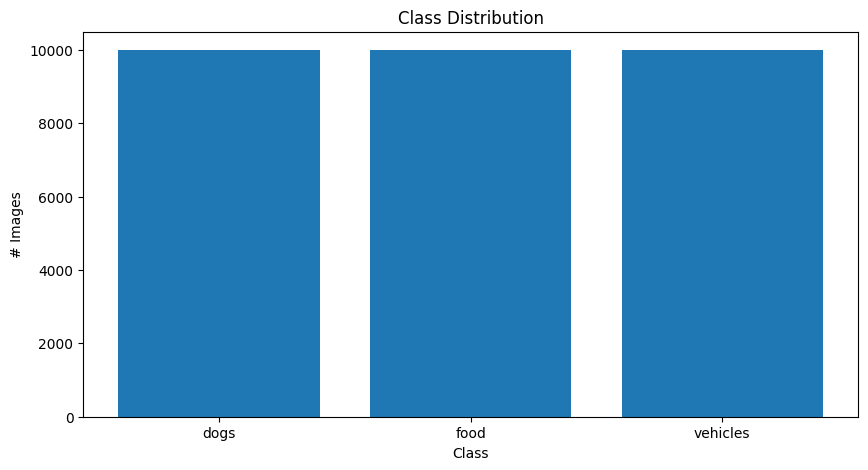

In [10]:
class_counts = np.bincount(dataset.targets)
class_labels = dataset.classes

plt.figure(figsize=(10, 5))
plt.bar(class_labels, class_counts)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('# Images')
plt.show()


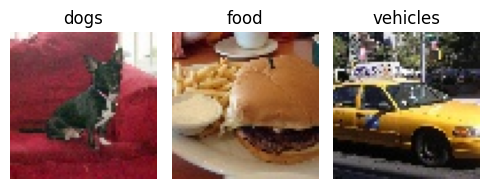

In [11]:

class_labels = dataset.classes
plt.figure(figsize=(5, 5))


for i, class_label in enumerate(class_labels):
    class_indices = np.where(np.array(dataset.targets) == i)[0]
    first_image_index = class_indices[0]
    sample_image, _ = dataset[first_image_index]

    # Display the image
    plt.subplot(1, len(class_labels), i + 1)
    plt.imshow(sample_image.permute(1, 2, 0))
    plt.title(class_label)
    plt.axis('off')

plt.tight_layout()
plt.show()


- SPlit the dataset

In [12]:
training_data_length = int(len(dataset) * 0.750)
train_data, temp = torch.utils.data.random_split(dataset, [training_data_length, len(dataset) - training_data_length])

In [13]:
vdata_length = int(len(temp) * 0.5)
valid_data, test_data = torch.utils.data.random_split(temp, [vdata_length, len(temp) - vdata_length])

In [14]:
batch_size = 32

In [15]:
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(valid_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 22500
Validation set size: 3750
Test set size: 3750


In [16]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## Define the VGG 13

In [17]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn

class VGG_13_CNN(nn.Module):
    def __init__(self, classes):
        super(VGG_13_CNN, self).__init__()
        self.conv = nn.Sequential(

            # First 2conv-3 64
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            #now we go with the macpool
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 2 conv with 128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            #Max pool again
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 2 - 256
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),

            # 2 512
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            #maxxxxxxxx pooooll
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 2 512
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(512*4, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, classes),
            # nn.Softmax(dim= 1)
        )


    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


In [18]:
classes = 3

model13 = VGG_13_CNN(classes)

In [19]:

optimizer = optim.Adam(model13.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

In [20]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model13.to(device)

summary(model13, (3, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
              ReLU-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
              ReLU-9          [-1, 128, 32, 32]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
             ReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         590,080
             ReLU-14          [-1, 256,

In [21]:
print(model13)

VGG_13_CNN(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16

### Functions to train and evaluate model, taken from the reference

In [22]:
def train_model(model, train_loader, valid_loader, optimizer, criterion, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        total_train_loss = 0
        train_predictions = []
        train_targets = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            train_predictions.extend(predicted.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_accuracy = accuracy_score(train_targets, train_predictions)
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        total_valid_loss = 0
        valid_predictions = []
        valid_targets = []

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_valid_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                valid_predictions.extend(predicted.cpu().numpy())
                valid_targets.extend(labels.cpu().numpy())

            valid_accuracy = accuracy_score(valid_targets, valid_predictions)
            avg_valid_loss = total_valid_loss / len(valid_loader)
            valid_losses.append(avg_valid_loss)
            valid_accuracies.append(valid_accuracy)

        end_time = time.time()
        epoch_time = end_time - start_time
        print(f"Epoch {epoch + 1}/{num_epochs} took {epoch_time:.2f} seconds. "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {avg_valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

    return train_losses, train_accuracies, valid_losses, valid_accuracies

In [23]:
num_epochs = 10
device = 'cuda'
train_losses, train_accuracies, valid_losses, valid_accuracies = train_model(model13, train_loader, valid_loader, optimizer, criterion, num_epochs)

Epoch 1/10 took 42.11 seconds. Train Loss: 0.7782, Train Accuracy: 0.6028, Validation Loss: 0.6189, Validation Accuracy: 0.7429
Epoch 2/10 took 42.29 seconds. Train Loss: 0.4661, Train Accuracy: 0.8219, Validation Loss: 0.3966, Validation Accuracy: 0.8485
Epoch 3/10 took 41.26 seconds. Train Loss: 0.4241, Train Accuracy: 0.8380, Validation Loss: 0.4077, Validation Accuracy: 0.8416
Epoch 4/10 took 41.67 seconds. Train Loss: 0.3530, Train Accuracy: 0.8673, Validation Loss: 0.3742, Validation Accuracy: 0.8595
Epoch 5/10 took 41.22 seconds. Train Loss: 0.3318, Train Accuracy: 0.8774, Validation Loss: 0.2988, Validation Accuracy: 0.8923
Epoch 6/10 took 41.39 seconds. Train Loss: 0.2876, Train Accuracy: 0.8946, Validation Loss: 0.3132, Validation Accuracy: 0.8843
Epoch 7/10 took 41.71 seconds. Train Loss: 0.2846, Train Accuracy: 0.8956, Validation Loss: 0.2759, Validation Accuracy: 0.8976
Epoch 8/10 took 41.41 seconds. Train Loss: 0.2589, Train Accuracy: 0.9064, Validation Loss: 0.3030, Vali

In [24]:

def evaluate_model(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    test_losses = []
    test_predictions = []
    test_targets = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            test_losses.append(loss.item())

            _, predicted = torch.max(outputs, 1)
            test_predictions.extend(predicted.cpu().numpy())
            test_targets.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(test_targets, test_predictions)
    test_f1 = f1_score(test_targets, test_predictions, average='weighted')
    test_precision = precision_score(test_targets, test_predictions, average='weighted')
    test_recall = recall_score(test_targets, test_predictions, average='weighted')
    test_loss = np.mean(test_losses)

    return test_accuracy, test_f1, test_precision, test_recall, test_loss,  test_targets, test_predictions


In [25]:
# Call evaluate_model to calculate test metrics
test_accuracy, test_f1, test_precision, test_recall, test_loss, test_targets, test_predictions = evaluate_model(model13, test_loader, criterion)

# Print test metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Loss: {test_loss:.4f}")

Test Accuracy: 0.9136
F1 Score: 0.9138
Precision: 0.9146
Recall: 0.9136
Loss: 0.2645


In [26]:
torch.save(model13.state_dict(), 'model_base.h5')

- TRAINING VS VALIDATION ACCURACY

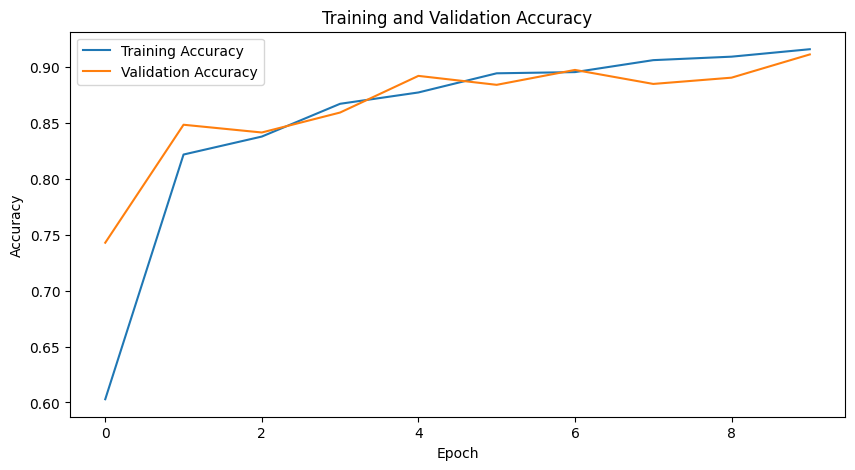

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


- TRAINING VS VALIDATION LOSS

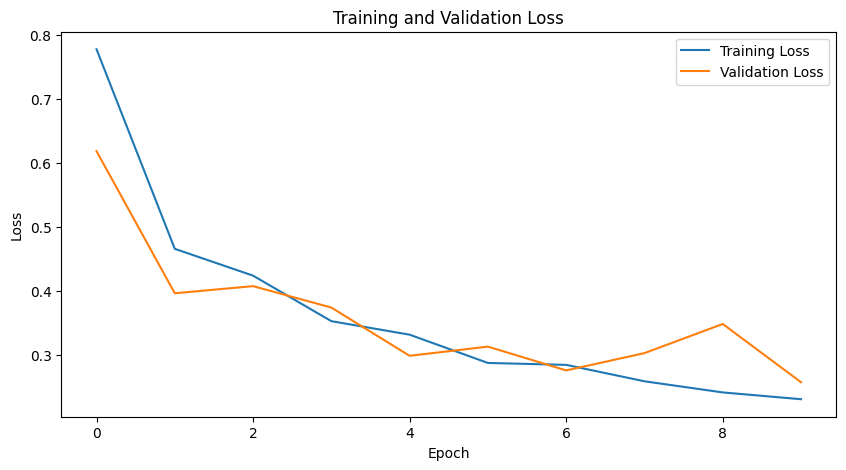

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


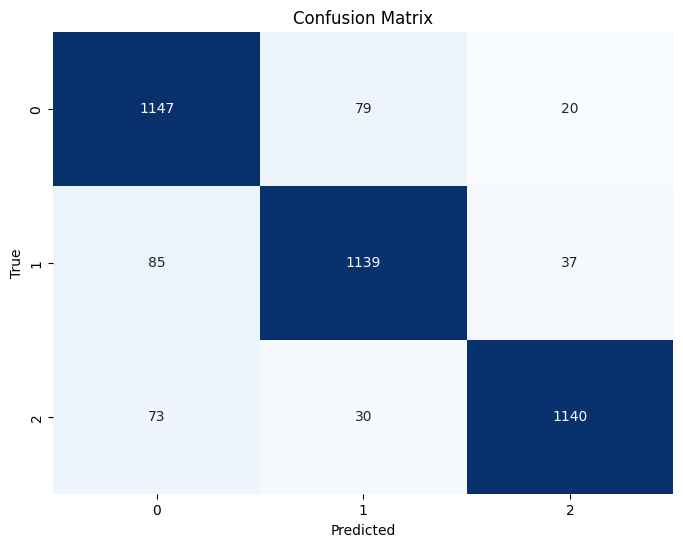

Precision: 0.9146
Recall: 0.9136
F1 Score: 0.9138


In [29]:
conf_matrix = confusion_matrix(test_targets, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(test_targets, test_predictions, average='weighted')
recall = recall_score(test_targets, test_predictions, average='weighted')
f1 = f1_score(test_targets, test_predictions, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

## Applying the Regularization

In [30]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn

class VGG_13_CNN_R(nn.Module):
    def __init__(self, classes, weight_decay):
        super(VGG_13_CNN_R, self).__init__()
        self.conv = nn.Sequential(

            # First 2conv-3 64
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            #now we go with the macpool
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 2 conv with 128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            #Max pool again
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 2 - 256
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),

            # 2 512
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            #maxxxxxxxx pooooll
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 2 512
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(512*4, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, classes),
            # nn.Softmax(dim= 1)
        )

        self.apply(self.init_weights)
        self.weight_decay = weight_decay

    def init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x




In [31]:
weight_decay = 0.00001
model_reg = VGG_13_CNN_R(classes, weight_decay)
optimizer = optim.Adam(model_reg.parameters(), lr=0.0001, weight_decay=weight_decay) # weight decay added to prevent the overfit

criterion = nn.CrossEntropyLoss()

In [32]:
num_epochs = 5  # Adjust as needed
device = 'cuda'
train_losses, train_accuracies, valid_losses, valid_accuracies = train_model(model_reg, train_loader, valid_loader, optimizer, criterion, num_epochs)

Epoch 1/5 took 43.19 seconds. Train Loss: 0.5388, Train Accuracy: 0.7780, Validation Loss: 0.3350, Validation Accuracy: 0.8725
Epoch 2/5 took 43.50 seconds. Train Loss: 0.3263, Train Accuracy: 0.8770, Validation Loss: 0.3127, Validation Accuracy: 0.8813
Epoch 3/5 took 42.92 seconds. Train Loss: 0.2523, Train Accuracy: 0.9065, Validation Loss: 0.2439, Validation Accuracy: 0.9171
Epoch 4/5 took 42.96 seconds. Train Loss: 0.2089, Train Accuracy: 0.9221, Validation Loss: 0.2328, Validation Accuracy: 0.9171
Epoch 5/5 took 46.10 seconds. Train Loss: 0.1687, Train Accuracy: 0.9376, Validation Loss: 0.2190, Validation Accuracy: 0.9240


In [33]:
# Call evaluate_model to calculate test metrics
test_accuracy, test_f1, test_precision, test_recall, test_loss, test_targets, test_predictions = evaluate_model(model_reg, test_loader, criterion)

# Print test metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Loss: {test_loss:.4f}")

Test Accuracy: 0.9245
F1 Score: 0.9244
Precision: 0.9245
Recall: 0.9245
Loss: 0.2117


In [34]:
torch.save(model_reg.state_dict(), 'model_regularization.h5')

- TRAINING VS VALIDATION ACCURACY

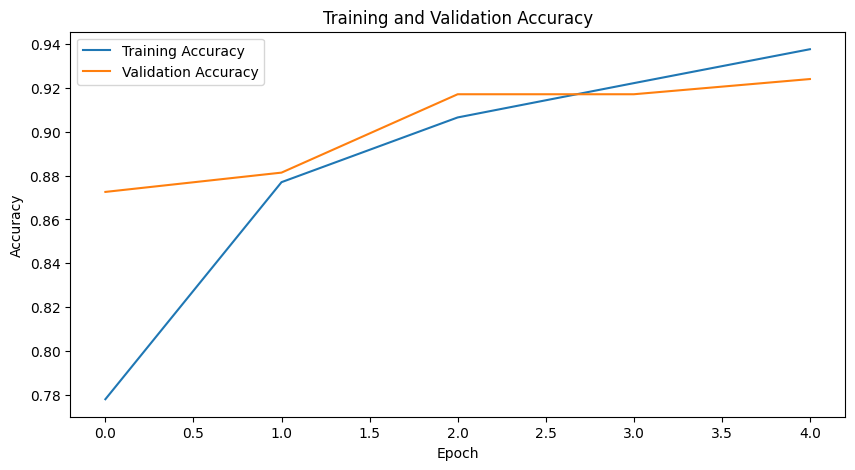

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


- TRAINING VS VALIDATION LOSS

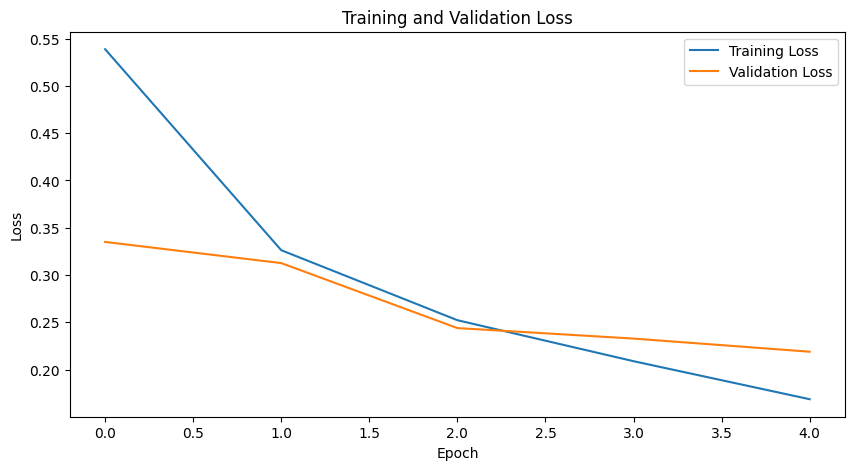

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


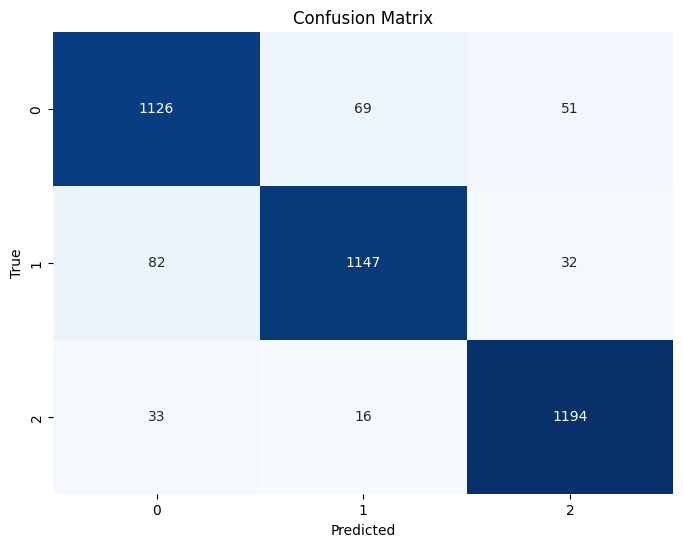

Precision: 0.9245
Recall: 0.9245
F1 Score: 0.9244


In [37]:
conf_matrix = confusion_matrix(test_targets, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(test_targets, test_predictions, average='weighted')
recall = recall_score(test_targets, test_predictions, average='weighted')
f1 = f1_score(test_targets, test_predictions, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

## Applying the Dropout

In [38]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn

class VGG_13_CNN_D(nn.Module):
    def __init__(self, classes, weight_decay):
        super(VGG_13_CNN_D, self).__init__()
        self.conv = nn.Sequential(

            # First 2conv-3 64
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            #now we go with the macpool
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 2 conv with 128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            #Max pool again
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 2 - 256
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),

            # 2 512
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            #maxxxxxxxx pooooll
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 2 512
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(512*4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),  # Add the dropout here
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),  # Add the dropout here
            nn.Linear(4096, classes),

        )

        self.apply(self.init_weights)
        self.weight_decay = weight_decay

    def init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x




In [39]:
weight_decay = 0.00001

model13_D = VGG_13_CNN_D(classes, weight_decay)
optimizer = optim.Adam(model13_D.parameters(), lr=0.0001, weight_decay = weight_decay)

In [40]:
num_epochs = 10
device = 'cuda'
train_losses, train_accuracies, valid_losses, valid_accuracies = train_model(model13_D, train_loader, valid_loader, optimizer, criterion, num_epochs)

Epoch 1/10 took 44.06 seconds. Train Loss: 0.5149, Train Accuracy: 0.7882, Validation Loss: 0.3633, Validation Accuracy: 0.8616
Epoch 2/10 took 42.74 seconds. Train Loss: 0.3253, Train Accuracy: 0.8785, Validation Loss: 0.3162, Validation Accuracy: 0.8888
Epoch 3/10 took 43.28 seconds. Train Loss: 0.2529, Train Accuracy: 0.9070, Validation Loss: 0.2485, Validation Accuracy: 0.9075
Epoch 4/10 took 43.02 seconds. Train Loss: 0.2046, Train Accuracy: 0.9242, Validation Loss: 0.2489, Validation Accuracy: 0.9072
Epoch 5/10 took 43.57 seconds. Train Loss: 0.1677, Train Accuracy: 0.9382, Validation Loss: 0.2136, Validation Accuracy: 0.9200
Epoch 6/10 took 43.15 seconds. Train Loss: 0.1328, Train Accuracy: 0.9499, Validation Loss: 0.2144, Validation Accuracy: 0.9221
Epoch 7/10 took 43.19 seconds. Train Loss: 0.1031, Train Accuracy: 0.9631, Validation Loss: 0.2354, Validation Accuracy: 0.9221
Epoch 8/10 took 42.94 seconds. Train Loss: 0.0739, Train Accuracy: 0.9734, Validation Loss: 0.2438, Vali

In [41]:
# Call evaluate_model to calculate test metrics
test_accuracy, test_f1, test_precision, test_recall, test_loss, test_targets, test_predictions = evaluate_model(model13_D, test_loader, criterion)

# Print test metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Loss: {test_loss:.4f}")

Test Accuracy: 0.9147
F1 Score: 0.9144
Precision: 0.9201
Recall: 0.9147
Loss: 0.3025


In [42]:
torch.save(model13_D.state_dict(), 'model_drop.h5')

- TRAINING VS VALIDATION ACCURACY

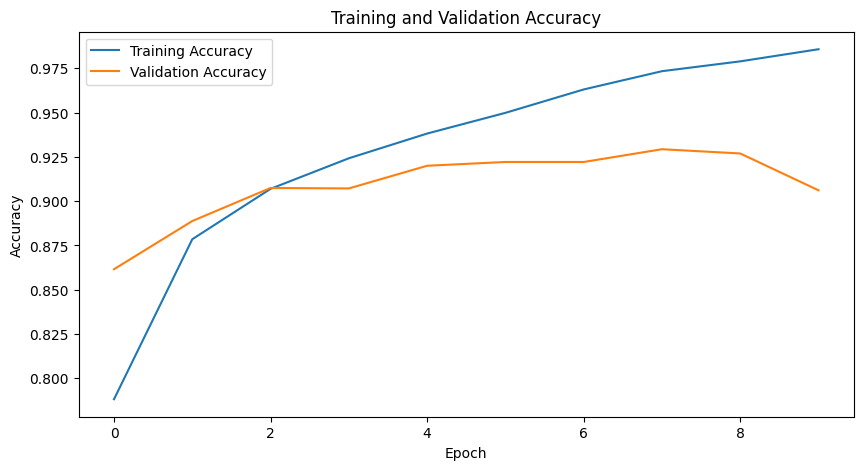

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


- TRAINING VS VALIDATION LOSS

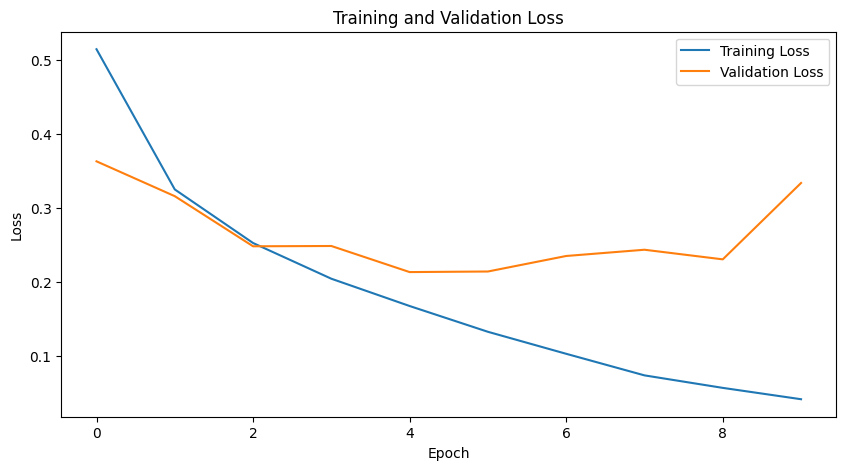

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


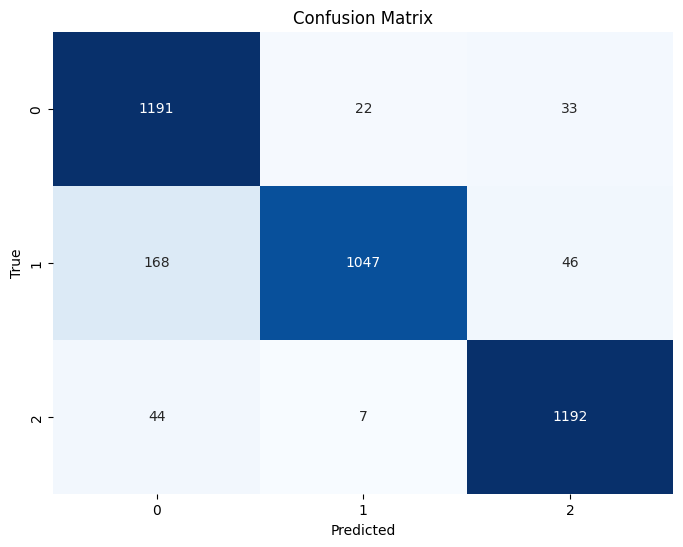

Precision: 0.9201
Recall: 0.9147
F1 Score: 0.9144


In [45]:
conf_matrix = confusion_matrix(test_targets, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(test_targets, test_predictions, average='weighted')
recall = recall_score(test_targets, test_predictions, average='weighted')
f1 = f1_score(test_targets, test_predictions, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

## Applying the Early stopping

In [46]:

def train_model_est(model, train_loader, valid_loader, optimizer, criterion, num_epochs, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    best_valid_loss = np.inf
    current_patience = 0

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        total_train_loss = 0
        train_predictions = []
        train_targets = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            train_predictions.extend(predicted.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_accuracy = accuracy_score(train_targets, train_predictions)
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        total_valid_loss = 0
        valid_predictions = []
        valid_targets = []

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_valid_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                valid_predictions.extend(predicted.cpu().numpy())
                valid_targets.extend(labels.cpu().numpy())

            valid_accuracy = accuracy_score(valid_targets, valid_predictions)
            avg_valid_loss = total_valid_loss / len(valid_loader)
            valid_losses.append(avg_valid_loss)
            valid_accuracies.append(valid_accuracy)

            # Check for early stopping
            if avg_valid_loss < best_valid_loss:
                best_valid_loss = avg_valid_loss
                current_patience = 0
            else:
                current_patience += 1
                if current_patience >= patience:
                    print("Early stopping triggered.")
                    break

        end_time = time.time()
        epoch_time = end_time - start_time
        print(f"Epoch {epoch + 1}/{num_epochs} took {epoch_time:.2f} seconds. "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {avg_valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

    return train_losses, train_accuracies, valid_losses, valid_accuracies


In [47]:
num_epochs = 10
device = 'cuda'
train_losses, train_accuracies, valid_losses, valid_accuracies = train_model_est(model13_D, train_loader, valid_loader, optimizer, criterion, num_epochs)

Epoch 1/10 took 42.97 seconds. Train Loss: 0.0380, Train Accuracy: 0.9876, Validation Loss: 0.2668, Validation Accuracy: 0.9285
Epoch 2/10 took 43.25 seconds. Train Loss: 0.0307, Train Accuracy: 0.9891, Validation Loss: 0.3031, Validation Accuracy: 0.9235
Epoch 3/10 took 42.90 seconds. Train Loss: 0.0284, Train Accuracy: 0.9900, Validation Loss: 0.3109, Validation Accuracy: 0.9237
Epoch 4/10 took 42.84 seconds. Train Loss: 0.0234, Train Accuracy: 0.9914, Validation Loss: 0.3104, Validation Accuracy: 0.9264
Epoch 5/10 took 43.01 seconds. Train Loss: 0.0221, Train Accuracy: 0.9924, Validation Loss: 0.3343, Validation Accuracy: 0.9317
Early stopping triggered.


In [48]:
# Call evaluate_model to calculate test metrics
test_accuracy, test_f1, test_precision, test_recall, test_loss, test_targets, test_predictions = evaluate_model(model13_D, test_loader, criterion)

# Print test metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Loss: {test_loss:.4f}")

Test Accuracy: 0.9288
F1 Score: 0.9289
Precision: 0.9299
Recall: 0.9288
Loss: 0.3208


In [49]:
torch.save(model13_D.state_dict(), 'model_early.h5')

- TRAINING VS VALIDATION ACCURACY

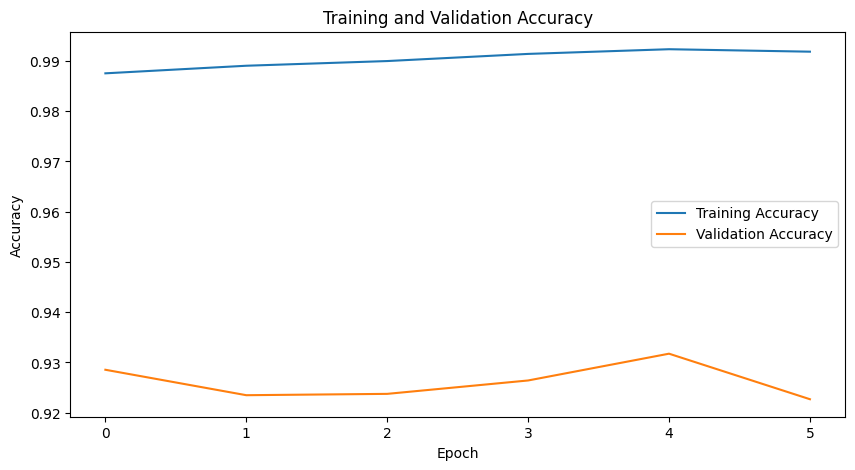

In [50]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


- TRAINING VS VALIDATION LOSS

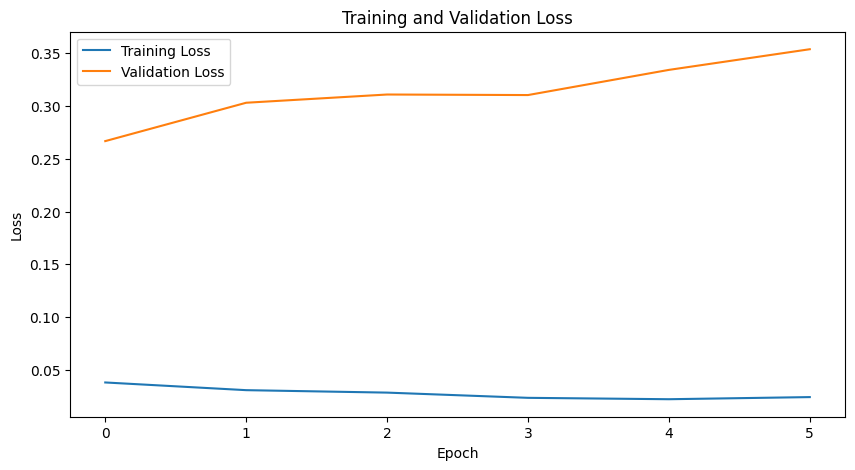

In [51]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


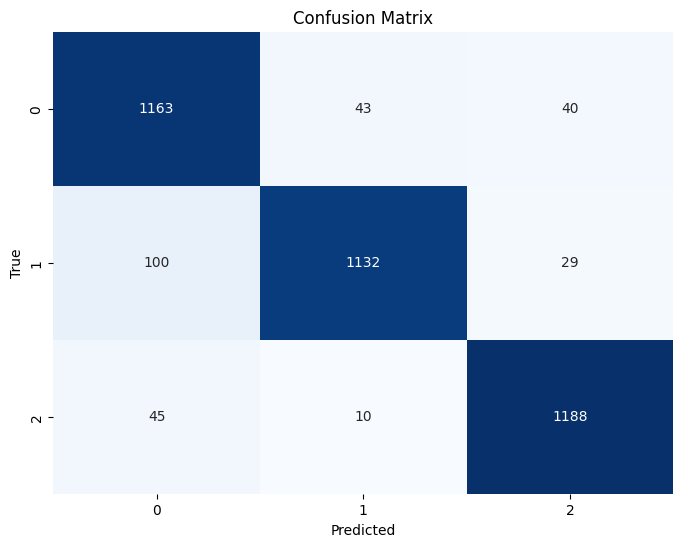

Precision: 0.9299
Recall: 0.9288
F1 Score: 0.9289


In [52]:
conf_matrix = confusion_matrix(test_targets, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(test_targets, test_predictions, average='weighted')
recall = recall_score(test_targets, test_predictions, average='weighted')
f1 = f1_score(test_targets, test_predictions, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

## Applying the Image augmentation

In [53]:
!unzip '/content/drive/MyDrive/DL/cnn_dataset.zip' -d '/content/dataset_for_aug'

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset_for_aug/vehicles/5499.jpg  
  inflating: /content/dataset_for_aug/vehicles/55.jpg  
  inflating: /content/dataset_for_aug/vehicles/550.jpg  
  inflating: /content/dataset_for_aug/vehicles/5500.jpg  
  inflating: /content/dataset_for_aug/vehicles/5501.jpg  
  inflating: /content/dataset_for_aug/vehicles/5502.jpg  
  inflating: /content/dataset_for_aug/vehicles/5503.jpg  
  inflating: /content/dataset_for_aug/vehicles/5504.jpg  
  inflating: /content/dataset_for_aug/vehicles/5505.jpg  
  inflating: /content/dataset_for_aug/vehicles/5506.jpg  
  inflating: /content/dataset_for_aug/vehicles/5507.jpg  
  inflating: /content/dataset_for_aug/vehicles/5508.jpg  
  inflating: /content/dataset_for_aug/vehicles/5509.jpg  
  inflating: /content/dataset_for_aug/vehicles/551.jpg  
  inflating: /content/dataset_for_aug/vehicles/5510.jpg  
  inflating: /content/dataset_for_aug/vehicles/5511.jpg  
  inflating: /content/dat

In [54]:
dataset_path = '/content/dataset_for_aug'

In [55]:
transform_data_n = transforms.Compose([
    transforms.Resize((64, 64)),                # Resize the image to 64x64
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(),    # Randomly flip the image vertically
    transforms.RandomRotation(20),      # Randomly rotate the image by a maximum of 20 degrees
    transforms.ColorJitter(brightness=0.4, contrast=0.3, saturation=0.1),  # Adjust brightness, contrast, saturation, and hue
    transforms.ToTensor(),              # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

# Create dataset with normalization
dataset = datasets.ImageFolder(dataset_path, transform=transform_data_n)

In [56]:
print("Number of images in the dataset", len(dataset))
print("Classes", dataset.classes)

Number of images in the dataset 30000
Classes ['dogs', 'food', 'vehicles']


In [57]:
sample_image, _ = dataset[0]
image_height, image_width = sample_image.shape[-2], sample_image.shape[-1]
print("Image size", image_height, "-", image_width)

Image size 64 - 64


In [58]:
n_chan = sample_image.shape[0]
print("Number of channels:", n_chan)

Number of channels: 3


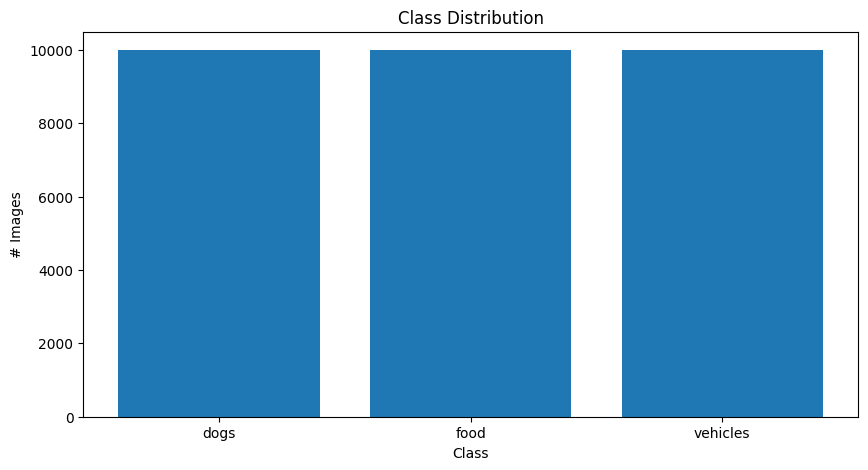

In [59]:
class_counts = np.bincount(dataset.targets)
class_labels = dataset.classes

plt.figure(figsize=(10, 5))
plt.bar(class_labels, class_counts)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('# Images')
plt.show()


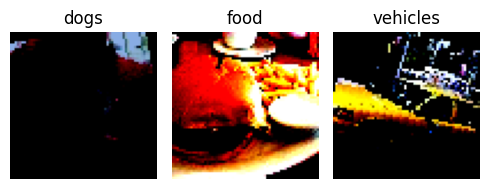

In [60]:

class_labels = dataset.classes
plt.figure(figsize=(5, 5))


for i, class_label in enumerate(class_labels):
    class_indices = np.where(np.array(dataset.targets) == i)[0]
    first_image_index = class_indices[0]
    sample_image, _ = dataset[first_image_index]

    # Display the image
    plt.subplot(1, len(class_labels), i + 1)
    plt.imshow(sample_image.permute(1, 2, 0))
    plt.title(class_label)
    plt.axis('off')

plt.tight_layout()
plt.show()


- SPlit the dataset

In [61]:
training_data_length = int(len(dataset) * 0.750)
train_data, temp = torch.utils.data.random_split(dataset, [training_data_length, len(dataset) - training_data_length])

In [62]:
vdata_length = int(len(temp) * 0.5)
valid_data, test_data = torch.utils.data.random_split(temp, [vdata_length, len(temp) - vdata_length])

In [63]:
batch_size = 32

In [64]:
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(valid_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 22500
Validation set size: 3750
Test set size: 3750


In [65]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [66]:

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model13.to(device)


### Functions to train and evaluate model, taken from the reference

In [68]:
num_epochs = 10
device = 'cuda'
train_losses, train_accuracies, valid_losses, valid_accuracies = train_model_est(model13_D, train_loader, valid_loader, optimizer, criterion, num_epochs)

Epoch 1/10 took 67.84 seconds. Train Loss: 0.2252, Train Accuracy: 0.9192, Validation Loss: 0.1954, Validation Accuracy: 0.9272
Epoch 2/10 took 64.61 seconds. Train Loss: 0.2068, Train Accuracy: 0.9248, Validation Loss: 0.2131, Validation Accuracy: 0.9219
Epoch 3/10 took 64.64 seconds. Train Loss: 0.1896, Train Accuracy: 0.9285, Validation Loss: 0.1757, Validation Accuracy: 0.9381
Epoch 4/10 took 64.28 seconds. Train Loss: 0.1766, Train Accuracy: 0.9347, Validation Loss: 0.1689, Validation Accuracy: 0.9381
Epoch 5/10 took 64.88 seconds. Train Loss: 0.1729, Train Accuracy: 0.9375, Validation Loss: 0.1736, Validation Accuracy: 0.9323
Epoch 6/10 took 69.62 seconds. Train Loss: 0.1643, Train Accuracy: 0.9412, Validation Loss: 0.1659, Validation Accuracy: 0.9421
Epoch 7/10 took 64.39 seconds. Train Loss: 0.1604, Train Accuracy: 0.9426, Validation Loss: 0.1585, Validation Accuracy: 0.9443
Epoch 8/10 took 64.42 seconds. Train Loss: 0.1516, Train Accuracy: 0.9444, Validation Loss: 0.1464, Vali

In [69]:
# Call evaluate_model to calculate test metrics
test_accuracy, test_f1, test_precision, test_recall, test_loss, test_targets, test_predictions = evaluate_model(model13_D, test_loader, criterion)

# Print test metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Loss: {test_loss:.4f}")

Test Accuracy: 0.9445
F1 Score: 0.9444
Precision: 0.9447
Recall: 0.9445
Loss: 0.1620


In [70]:
torch.save(model13_D.state_dict(), 'model_aug.h5')

- TRAINING VS VALIDATION ACCURACY

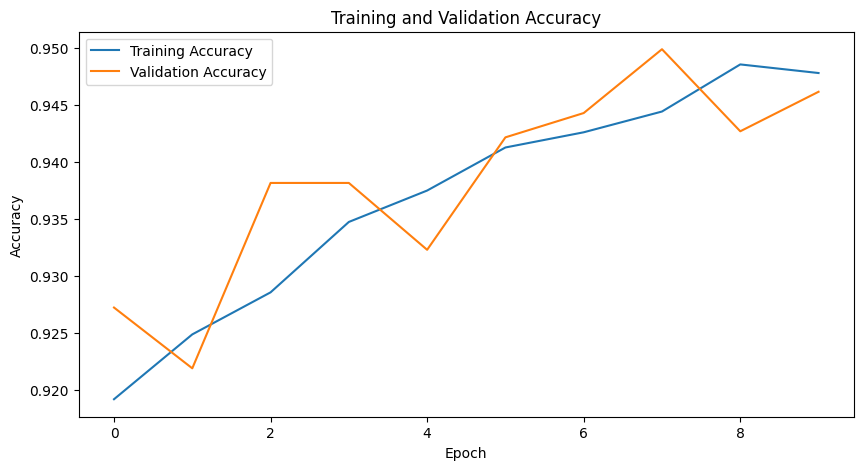

In [71]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


- TRAINING VS VALIDATION LOSS

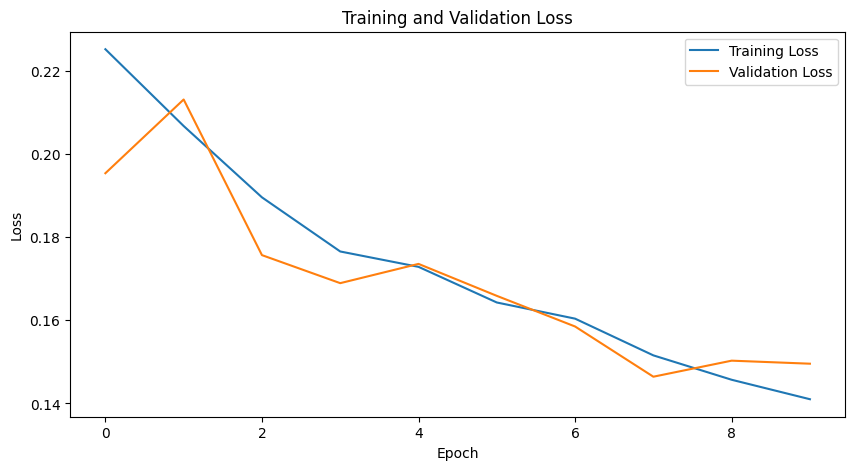

In [72]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


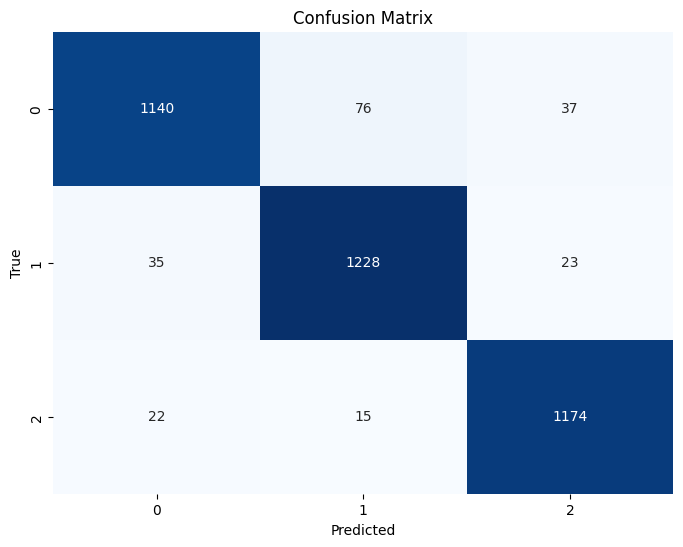

Precision: 0.9447
Recall: 0.9445
F1 Score: 0.9444


In [73]:
conf_matrix = confusion_matrix(test_targets, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(test_targets, test_predictions, average='weighted')
recall = recall_score(test_targets, test_predictions, average='weighted')
f1 = f1_score(test_targets, test_predictions, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')